## introduction

## table of contents

## import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import calendar

In [2]:
import glob

from os import listdir

filepaths = [f for f in listdir("./data") if f.endswith('.csv')]
df = pd.concat(map(pd.read_csv, filepaths))

OR

df = pd.concat(map(pd.read_csv, ['data/d1.csv', 'data/d2.csv','data/d3.csv']))

## import data

In [3]:
df_all = pd.concat(map(pd.read_csv, glob.glob('data/*.csv')))

In [4]:
df_all.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'country_displayable_name', 'created_at', 'creator',
       'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'friends',
       'fx_rate', 'goal', 'id', 'is_backing', 'is_starrable', 'is_starred',
       'launched_at', 'location', 'name', 'permissions', 'photo', 'pledged',
       'profile', 'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type'],
      dtype='object')

In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213583 entries, 0 to 3679
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   backers_count             213583 non-null  int64  
 1   blurb                     213576 non-null  object 
 2   category                  213583 non-null  object 
 3   converted_pledged_amount  213583 non-null  int64  
 4   country                   213583 non-null  object 
 5   country_displayable_name  213583 non-null  object 
 6   created_at                213583 non-null  int64  
 7   creator                   213583 non-null  object 
 8   currency                  213583 non-null  object 
 9   currency_symbol           213583 non-null  object 
 10  currency_trailing_code    213583 non-null  bool   
 11  current_currency          213583 non-null  object 
 12  deadline                  213583 non-null  int64  
 13  disable_communication     213583 non-null  boo

In [6]:
df_all.shape

(213583, 38)

## data preprocessing

### for non useful columns

In [7]:
# drop columns containing mostly null values
df = df_all.drop(['friends', 'is_backing', 'is_starred', 'permissions'], axis=1, inplace=False)

Other columns are not useful for the purposes of this project, and can also be dropped for these reasons:

- converted_pledged_amount - most currencies are converted into USD in this column, but not all. Instead, the 'usd_pledged' column will be used as these all use the same currency (the dollar).
- creator - most projects are by different people, and so this cannot be usefully used to group or categorise projects, and is not useful in a machine learning context.
- currency - all currency values will be used as/converted to dollars, so that they can be evaluated together. It is not necessary to keep the original record because of this, and because it will be highly correlated with country (which will be kept).
- currency_symbol - as above.
- currency_trailing_code - as above.
- current_currency - as above.
- fx_rate - this is used to create 'converted_pledged_amount' from 'pledged', but does not always convert to dollars so can be dropped in favour of 'static_usd_rate' which always converts to dollars.
- photo - image processing/computer vision will not be used in this project.
- pledged - data in this column is stored in native currencies, so this will be dropped in favour of 'usd_pledged' which is all in the same currency (dollars).
- profile - this column contains a combination of information from other columns (e.g. id, state, dates, url).
- slug - this is simply the 'name' column with hyphens instead of spaces.
- source_url - the sites that the rows were each scraped from is not useful for building a model, as each is unique to an id.
- spotlight - projects can only be spotlighted after they are already successful, so this will be entirely correlated with successful projects.
- state_changed_at - this is the same as deadline for most projects. The only exceptions are for projects which were cancelled before their deadline, but they will not be included in this analysis.
- urls - as with source_url.
- usd_type - it is unclear what this column means, but it is unlikely to be necessary since all currency values will be converted to dollars, and other currency information has been dropped.

In [8]:
# drop columns that are not useful
df.drop(['converted_pledged_amount', 'creator', 'currency', 'currency_symbol', 
         'currency_trailing_code', 'current_currency', 'fx_rate', 'photo', 'pledged', 
         'profile', 'slug', 'source_url', 'spotlight', 'state_changed_at', 'urls', 
         'usd_type'], axis=1, inplace=True)

### for datetime columns

In [9]:
# Converting dates from unix to datetime
date_cols = ['created_at', 'deadline', 'launched_at']
for col in date_cols:
    df[[col]] = pd.to_datetime(df[col], origin='unix', unit='s')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213583 entries, 0 to 3679
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   backers_count             213583 non-null  int64         
 1   blurb                     213576 non-null  object        
 2   category                  213583 non-null  object        
 3   country                   213583 non-null  object        
 4   country_displayable_name  213583 non-null  object        
 5   created_at                213583 non-null  datetime64[ns]
 6   deadline                  213583 non-null  datetime64[ns]
 7   disable_communication     213583 non-null  bool          
 8   goal                      213583 non-null  float64       
 9   id                        213583 non-null  int64         
 10  is_starrable              213583 non-null  bool          
 11  launched_at               213583 non-null  datetime64[ns]
 12  loca

### for duplicate rows

In [11]:
#see possible duplicate rows by 'id'
df.duplicated(subset='id').sum()

25769

In [12]:
#see possible duplicate rows by 'blurb'
df.duplicated(subset='blurb').sum()

27420

In [13]:
ids = df["id"]
df[ids.isin(ids[ids.duplicated()])]

,backers_count,blurb,category,country,country_displayable_name,created_at,deadline,disable_communication,goal,id,is_starrable,launched_at,location,name,staff_pick,state,static_usd_rate,usd_pledged
2,267,Wonderful 3D Popup Christmas Cards. Opening th...,"{""id"":351,""name"":""Printing"",""slug"":""crafts/pri...",DE,Germany,2015-10-08 07:24:00,2015-11-08 21:00:00,False,2500.0,1484057434,False,2015-10-16 01:09:33,"{""id"":554890,""name"":""Copenhagen"",""slug"":""copen...","Wonderful 3D Popup Christmas Cards: Small, Yet...",True,successful,1.139062,11653.747824
3,96,Hi everyone. I love animals and I love to croc...,"{""id"":344,""name"":""Crochet"",""slug"":""crafts/croc...",CA,Canada,2019-01-14 17:46:58,2019-02-20 16:03:10,False,100.0,1955625514,False,2019-01-21 16:03:10,"{""id"":4177,""name"":""Halifax"",""slug"":""halifax-ca...",Animal Scarves to Help the Animals!,False,successful,0.754100,1641.894476
4,444,"Slim, Earth-friendly hangers with an innovativ...","{""id"":28,""name"":""Product Design"",""slug"":""desig...",US,the United States,2018-05-29 01:14:34,2020-08-22 14:56:04,False,7500.0,814342621,False,2020-07-13 14:56:04,"{""id"":2487956,""name"":""San Francisco"",""slug"":""s...",Mozu Hanger - The Friendliest Hanger on the Pl...,False,successful,1.000000,26752.000000
7,3,"Introducing the Primal Conceps ""LUCILLE"" produ...","{""id"":356,""name"":""Woodworking"",""slug"":""crafts/...",US,the United States,2017-03-06 22:30:36,2017-04-12 16:13:36,False,100.0,1403250866,False,2017-03-13 16:13:36,"{""id"":2450465,""name"":""Midland"",""slug"":""midland...",Lucy Keychain bats,False,successful,1.000000,171.000000
9,32,The Seven Handmade Mechanical Models with Stea...,"{""id"":345,""name"":""DIY"",""slug"":""crafts/diy"",""po...",HK,Hong Kong,2018-05-07 14:20:46,2018-06-14 15:31:47,False,15000.0,615857771,False,2018-05-15 15:31:47,"{""id"":2165352,""name"":""Hong Kong"",""slug"":""hong-...",The Battle Warriors of Steam Punks,False,successful,0.127389,3286.861792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3674,26,Bronwyn: The Further Adventures- Issue 1,"{""id"":250,""name"":""Comic Books"",""slug"":""comics/...",AU,Australia,2020-07-09 01:30:11,2020-08-16 03:20:06,False,1000.0,1251772211,False,2020-07-17 03:20:06,"{""id"":1105779,""name"":""Sydney"",""slug"":""sydney-a...",Bronwyn- The Further Adventures- Issue 1,False,successful,0.699198,825.276829
3675,27,I have received a scholarship to the famous Br...,"{""id"":255,""name"":""Residencies"",""slug"":""dance/r...",GB,the United Kingdom,2016-06-28 21:11:16,2016-08-26 19:37:00,False,1000.0,434619322,False,2016-07-25 13:26:30,"{""id"":2459115,""name"":""New York"",""slug"":""new-yo...",Help support me in NEW YORK!,False,successful,1.313831,1625.208737
3676,206,MONSTERS✔️ ALIENS✔️ DEMONS✔️ KILLER CLOWNS✔️ T...,"{""id"":250,""name"":""Comic Books"",""slug"":""comics/...",US,the United States,2021-01-03 21:55:08,2021-03-06 05:00:00,False,2000.0,1262668783,False,2021-02-06 02:01:16,"{""id"":2469017,""name"":""Pasco"",""slug"":""pasco-wa""...",DEAD END #1,False,successful,1.000000,9816.000000
3677,31,Anna Reyes is a 2015 Resident Dance Artist for...,"{""id"":255,""name"":""Residencies"",""slug"":""dance/r...",US,the United States,2015-03-09 22:27:52,2015-06-27 03:59:00,False,2500.0,2037776650,False,2015-05-28 02:02:43,"{""id"":2367105,""name"":""Boston"",""slug"":""boston-m...",The Good Parts of Being Alive - Boston Center ...,True,successful,1.000000,2636.000000


In [14]:
blurbs = df["blurb"]
df[blurbs.isin(blurbs[blurbs.duplicated()])]

,backers_count,blurb,category,country,country_displayable_name,created_at,deadline,disable_communication,goal,id,is_starrable,launched_at,location,name,staff_pick,state,static_usd_rate,usd_pledged
2,267,Wonderful 3D Popup Christmas Cards. Opening th...,"{""id"":351,""name"":""Printing"",""slug"":""crafts/pri...",DE,Germany,2015-10-08 07:24:00,2015-11-08 21:00:00,False,2500.0,1484057434,False,2015-10-16 01:09:33,"{""id"":554890,""name"":""Copenhagen"",""slug"":""copen...","Wonderful 3D Popup Christmas Cards: Small, Yet...",True,successful,1.139062,11653.747824
3,96,Hi everyone. I love animals and I love to croc...,"{""id"":344,""name"":""Crochet"",""slug"":""crafts/croc...",CA,Canada,2019-01-14 17:46:58,2019-02-20 16:03:10,False,100.0,1955625514,False,2019-01-21 16:03:10,"{""id"":4177,""name"":""Halifax"",""slug"":""halifax-ca...",Animal Scarves to Help the Animals!,False,successful,0.754100,1641.894476
4,444,"Slim, Earth-friendly hangers with an innovativ...","{""id"":28,""name"":""Product Design"",""slug"":""desig...",US,the United States,2018-05-29 01:14:34,2020-08-22 14:56:04,False,7500.0,814342621,False,2020-07-13 14:56:04,"{""id"":2487956,""name"":""San Francisco"",""slug"":""s...",Mozu Hanger - The Friendliest Hanger on the Pl...,False,successful,1.000000,26752.000000
7,3,"Introducing the Primal Conceps ""LUCILLE"" produ...","{""id"":356,""name"":""Woodworking"",""slug"":""crafts/...",US,the United States,2017-03-06 22:30:36,2017-04-12 16:13:36,False,100.0,1403250866,False,2017-03-13 16:13:36,"{""id"":2450465,""name"":""Midland"",""slug"":""midland...",Lucy Keychain bats,False,successful,1.000000,171.000000
9,32,The Seven Handmade Mechanical Models with Stea...,"{""id"":345,""name"":""DIY"",""slug"":""crafts/diy"",""po...",HK,Hong Kong,2018-05-07 14:20:46,2018-06-14 15:31:47,False,15000.0,615857771,False,2018-05-15 15:31:47,"{""id"":2165352,""name"":""Hong Kong"",""slug"":""hong-...",The Battle Warriors of Steam Punks,False,successful,0.127389,3286.861792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3674,26,Bronwyn: The Further Adventures- Issue 1,"{""id"":250,""name"":""Comic Books"",""slug"":""comics/...",AU,Australia,2020-07-09 01:30:11,2020-08-16 03:20:06,False,1000.0,1251772211,False,2020-07-17 03:20:06,"{""id"":1105779,""name"":""Sydney"",""slug"":""sydney-a...",Bronwyn- The Further Adventures- Issue 1,False,successful,0.699198,825.276829
3675,27,I have received a scholarship to the famous Br...,"{""id"":255,""name"":""Residencies"",""slug"":""dance/r...",GB,the United Kingdom,2016-06-28 21:11:16,2016-08-26 19:37:00,False,1000.0,434619322,False,2016-07-25 13:26:30,"{""id"":2459115,""name"":""New York"",""slug"":""new-yo...",Help support me in NEW YORK!,False,successful,1.313831,1625.208737
3676,206,MONSTERS✔️ ALIENS✔️ DEMONS✔️ KILLER CLOWNS✔️ T...,"{""id"":250,""name"":""Comic Books"",""slug"":""comics/...",US,the United States,2021-01-03 21:55:08,2021-03-06 05:00:00,False,2000.0,1262668783,False,2021-02-06 02:01:16,"{""id"":2469017,""name"":""Pasco"",""slug"":""pasco-wa""...",DEAD END #1,False,successful,1.000000,9816.000000
3677,31,Anna Reyes is a 2015 Resident Dance Artist for...,"{""id"":255,""name"":""Residencies"",""slug"":""dance/r...",US,the United States,2015-03-09 22:27:52,2015-06-27 03:59:00,False,2500.0,2037776650,False,2015-05-28 02:02:43,"{""id"":2367105,""name"":""Boston"",""slug"":""boston-m...",The Good Parts of Being Alive - Boston Center ...,True,successful,1.000000,2636.000000


In [15]:
#see 'id' for rows where blurbs are duplicates
df[blurbs.isin(blurbs[blurbs.duplicated()])]['id']

2       1484057434
3       1955625514
4        814342621
7       1403250866
9        615857771
           ...    
3674    1251772211
3675     434619322
3676    1262668783
3677    2037776650
3679     392338575
Name: id, Length: 53989, dtype: int64

explore ids #175864201 and #262646351 where blurbs are identical but ids are not identical;
per below, choosing to keep observations for ids #175864201 and #262646351

In [16]:
df.iloc[2561] == df.iloc[2994]

backers_count               False
blurb                       False
category                    False
country                      True
country_displayable_name     True
created_at                  False
deadline                    False
disable_communication        True
goal                        False
id                          False
is_starrable                 True
launched_at                 False
location                    False
name                        False
staff_pick                   True
state                       False
static_usd_rate              True
usd_pledged                 False
dtype: bool

### extracting categories and subcategories

In [17]:
# Example category value
df.iloc[0]['category']

'{"id":356,"name":"Woodworking","slug":"crafts/woodworking","position":14,"parent_id":26,"parent_name":"Crafts","color":16744876,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/crafts/woodworking"}}}'

In [18]:
# Extracting the relevant sub-category section from the string
f = lambda x: x['category'].split('/')[1].split('","position')[0]
df['sub_category'] = df.apply(f, axis=1)

# Extracting the relevant category section from the string, and replacing the original category variable
f = lambda x: x['category'].split('"slug":"')[1].split('/')[0]
df['category'] = df.apply(f, axis=1)
f = lambda x: x['category'].split('","position"')[0] # Some categories do not have a sub-category, so do not have a '/' to split with
df['category'] = df.apply(f, axis=1)

### calculating additional features

In [19]:
# Time between creating and launching a project
df['creation_to_launch_days'] = df['launched_at'] - df['created_at']
df['creation_to_launch_days'] = df['creation_to_launch_days'].dt.round('d').dt.days # Rounding to nearest days, then showing as number only
# Or could show as number of hours:
# df['creation_to_launch_hours'] = df['launched_at'] - df['created_at']
# df['creation_to_launch_hours'] = df['creation_to_launch_hours'].dt.round('h') / np.timedelta64(1, 'h') 

# Campaign length
df['campaign_days'] = df['deadline'] - df['launched_at']
df['campaign_days'] = df['campaign_days'].dt.round('d').dt.days # Rounding to nearest days, then showing as number only

# Launch day of week
df['launch_day'] = df['launched_at'].dt.day_name()

# Deadline day of week
df['deadline_day'] = df['deadline'].dt.day_name()

# Launch month
df['launch_month'] = df['launched_at'].dt.month_name()

# Deadline month
df['deadline_month'] = df['deadline'].dt.month_name()

In [20]:
# Launch time
df['launch_hour'] = df['launched_at'].dt.hour # Extracting hour from launched_at

def two_hour_launch(row):
    '''Creates two hour bins from the launch_hour column'''
    if row['launch_hour'] in (0,1):
        return '12am-2am'
    if row['launch_hour'] in (2,3):
        return '2am-4am'
    if row['launch_hour'] in (4,5):
        return '4am-6am'
    if row['launch_hour'] in (6,7):
        return '6am-8am'
    if row['launch_hour'] in (8,9):
        return '8am-10am'
    if row['launch_hour'] in (10,11):
        return '10am-12pm'
    if row['launch_hour'] in (12,13):
        return '12pm-2pm'
    if row['launch_hour'] in (14,15):
        return '2pm-4pm'
    if row['launch_hour'] in (16,17):
        return '4pm-6pm'
    if row['launch_hour'] in (18,19):
        return '6pm-8pm'
    if row['launch_hour'] in (20,21):
        return '8pm-10pm'
    if row['launch_hour'] in (22,23):
        return '10pm-12am'
    
df['launch_time'] = df.apply(two_hour_launch, axis=1) # Calculates bins from launch_time

df.drop('launch_hour', axis=1, inplace=True)

In [21]:
# Deadline time
df['deadline_hour'] = df['deadline'].dt.hour # Extracting hour from deadline

def two_hour_deadline(row):
    '''Creates two hour bins from the deadline_hour column'''
    if row['deadline_hour'] in (0,1):
        return '12am-2am'
    if row['deadline_hour'] in (2,3):
        return '2am-4am'
    if row['deadline_hour'] in (4,5):
        return '4am-6am'
    if row['deadline_hour'] in (6,7):
        return '6am-8am'
    if row['deadline_hour'] in (8,9):
        return '8am-10am'
    if row['deadline_hour'] in (10,11):
        return '10am-12pm'
    if row['deadline_hour'] in (12,13):
        return '12pm-2pm'
    if row['deadline_hour'] in (14,15):
        return '2pm-4pm'
    if row['deadline_hour'] in (16,17):
        return '4pm-6pm'
    if row['deadline_hour'] in (18,19):
        return '6pm-8pm'
    if row['deadline_hour'] in (20,21):
        return '8pm-10pm'
    if row['deadline_hour'] in (22,23):
        return '10pm-12am'
    
df['deadline_time'] = df.apply(two_hour_deadline, axis=1) # Calculates bins from launch_time

df.drop('deadline_hour', axis=1, inplace=True)

In [22]:
# Mean pledge per backer
df['pledge_per_backer'] = round(df['usd_pledged']/df['backers_count'],2)

In [23]:
# Calculate new column 'usd_goal' as goal * static_usd_rate
df['usd_goal'] = round(df['goal'] * df['static_usd_rate'],2)

### drop features

In [24]:
# Dropping goal and static_usd_rate
df.drop(['goal', 'static_usd_rate'], axis=1, inplace=True)

In [36]:
# Drop blurb variable
df.drop('blurb', axis=1, inplace=True)

In [40]:
# Drop country_displayable_name
df.drop('country_displayable_name', axis=1, inplace=True)

In [37]:
# Drop state of communication
df.drop('disable_communication', axis=1, inplace=True)

In [38]:
# Dropping location
df.drop('location', axis=1, inplace=True)

In [42]:
# Drop name variable
df.drop('name', axis=1, inplace=True)

### target of interest

In [46]:
df = df[df['state'].isin(['successful', 'failed'])]

### setting the index

In [25]:
# Setting the id column as the index
df.set_index('id', inplace=True)

In [43]:
df.head()

,backers_count,category,country,created_at,deadline,is_starrable,launched_at,staff_pick,state,usd_pledged,...,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer,usd_goal
id,,,,,,,,,,,,,,,,,,,,,
2139821925,4,crafts,US,2015-12-04 03:38:52,2016-01-03 16:41:03,False,2015-12-04 16:41:03,False,failed,200.000000,...,1,30,Friday,Sunday,December,January,4pm-6pm,4pm-6pm,50.00,1000.00
378093839,545,comics,US,2017-05-06 17:40:01,2017-09-29 00:00:00,False,2017-08-29 14:00:07,True,successful,26773.000000,...,115,30,Tuesday,Friday,August,September,2pm-4pm,12am-2am,49.12,20000.00
1484057434,267,crafts,DE,2015-10-08 07:24:00,2015-11-08 21:00:00,False,2015-10-16 01:09:33,True,successful,11653.747824,...,8,24,Friday,Sunday,October,November,12am-2am,8pm-10pm,43.65,2847.66
1955625514,96,crafts,CA,2019-01-14 17:46:58,2019-02-20 16:03:10,False,2019-01-21 16:03:10,False,successful,1641.894476,...,7,30,Monday,Wednesday,January,February,4pm-6pm,4pm-6pm,17.10,75.41
814342621,444,design,US,2018-05-29 01:14:34,2020-08-22 14:56:04,False,2020-07-13 14:56:04,False,successful,26752.000000,...,777,40,Monday,Saturday,July,August,2pm-4pm,2pm-4pm,60.25,7500.00


In [48]:
df.to_csv('data/processed_data.csv')

## EDA

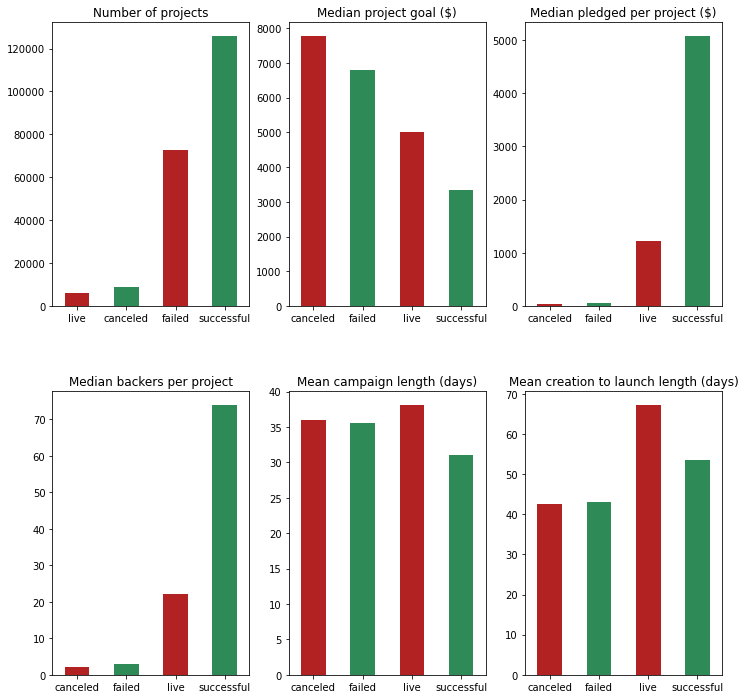

In [28]:
# Plotting the average amount pledged to successful and unsuccesful projects
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12,12))

df['state'].value_counts(ascending=True).plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'], rot=0)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

df.groupby('state').usd_goal.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'], rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('state').usd_pledged.median().plot(kind='bar', ax=ax3, color=['firebrick', 'seagreen'], rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

df.groupby('state').backers_count.median().plot(kind='bar', ax=ax4, color=['firebrick', 'seagreen'], rot=0)
ax4.set_title('Median backers per project')
ax4.set_xlabel('')

df.groupby('state').campaign_days.mean().plot(kind='bar', ax=ax5, color=['firebrick', 'seagreen'], rot=0)
ax5.set_title('Mean campaign length (days)')
ax5.set_xlabel('')

df.groupby('state').creation_to_launch_days.mean().plot(kind='bar', ax=ax6, color=['firebrick', 'seagreen'], rot=0)
ax6.set_title('Mean creation to launch length (days)')
ax6.set_xlabel('')

# df.groupby('state').name_length.mean().plot(kind='bar', ax=ax7, color=['firebrick', 'seagreen'], rot=0)
# ax7.set_title('Mean name length (words)')
# ax7.set_xlabel('')

# df.groupby('state').blurb_length.mean().plot(kind='bar', ax=ax8, color=['firebrick', 'seagreen'], rot=0)
# ax8.set_title('Mean blurb length (words)')
# ax8.set_xlabel('')

# # Creating a dataframe grouped by staff_pick with columns for failed and successful
# pick_df = pd.get_dummies(df.set_index('staff_pick').state).groupby('staff_pick').sum()
# # Normalizes counts by column, and selects the 'True' category (iloc[1])
# (pick_df.div(pick_df.sum(axis=0), axis=1)).iloc[1].plot(kind='bar', ax=ax9, color=['firebrick', 'seagreen'], rot=0) 
# ax9.set_title('Proportion that are staff picks')
# ax9.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

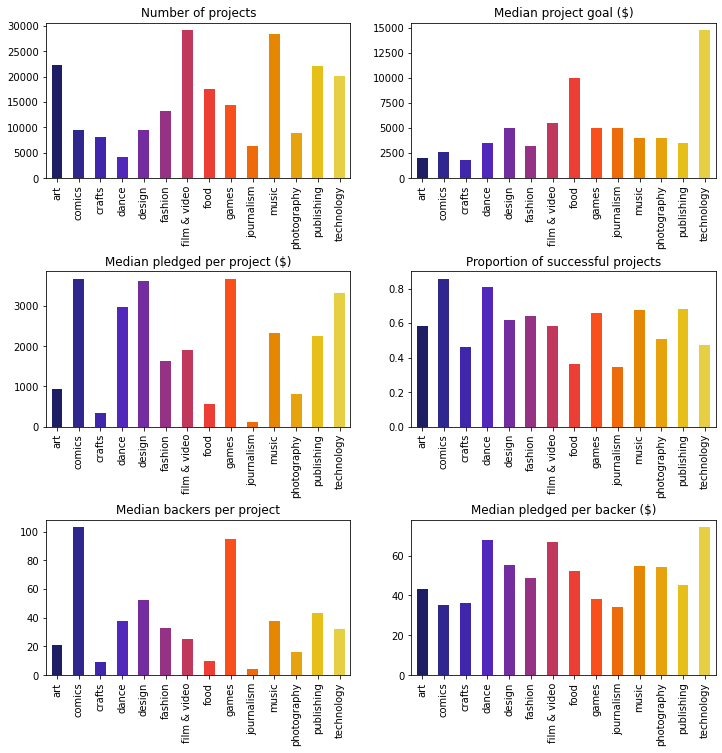

In [29]:
# Creating a dataframe grouped by category with columns for failed and successful
cat_df = pd.get_dummies(df.set_index('category').state).groupby('category').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.category.nunique())) # Setting a colormap

df.groupby('category').category.count().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

df.groupby('category').usd_goal.median().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('category').usd_pledged.median().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

cat_df.div(cat_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax4, color=color) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

df.groupby('category').backers_count.median().plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

df.groupby('category').pledge_per_backer.median().plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.6)
plt.show()

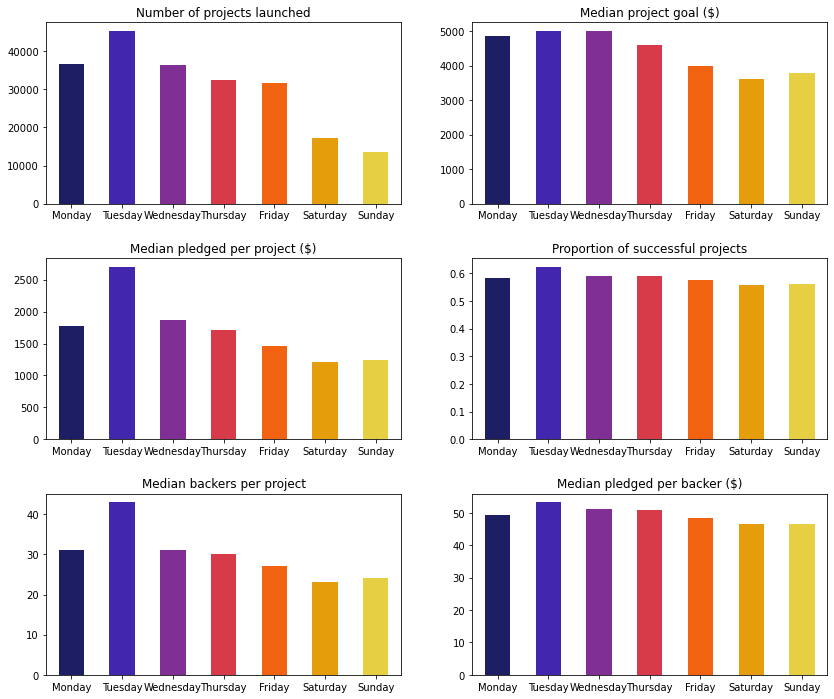

In [30]:
# Creating a dataframe grouped by the day on which they were launched, with columns for failed and successful
day_df = pd.get_dummies(df.set_index('launch_day').state).groupby('launch_day').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_day.nunique()))

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df.groupby('launch_day').launch_day.count().reindex(weekdays).plot(kind='bar', ax=ax1, color=color, rot=0)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')

df.groupby('launch_day').usd_goal.median().reindex(weekdays).plot(kind='bar', ax=ax2, color=color, rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('launch_day').usd_pledged.median().reindex(weekdays).plot(kind='bar', ax=ax3, color=color, rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

day_df.div(day_df.sum(axis=1), axis=0).successful.reindex(weekdays).plot(kind='bar', ax=ax4, color=color, rot=0) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

df.groupby('launch_day').backers_count.median().reindex(weekdays).plot(kind='bar', ax=ax5, color=color, rot=0)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

df.groupby('launch_day').pledge_per_backer.median().reindex(weekdays).plot(kind='bar', ax=ax6, color=color, rot=0)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

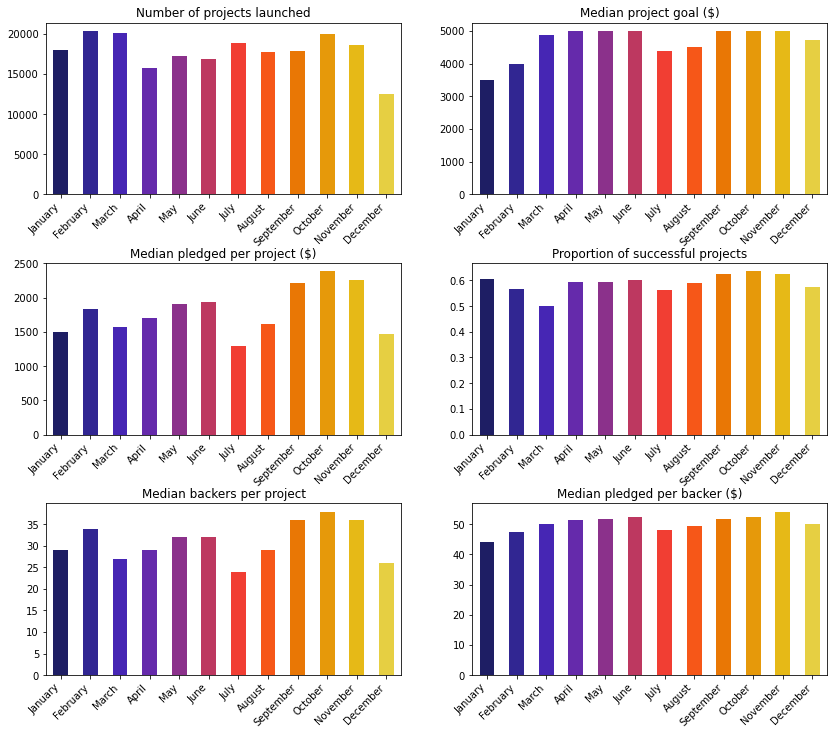

In [31]:
# Creating a dataframe grouped by the month in which they were launched, with columns for failed and successful
month_df = pd.get_dummies(df.set_index('launch_month').state).groupby('launch_month').sum()

# Plotting
months = list(calendar.month_name)[1:]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_month.nunique()))

df.groupby('launch_month').launch_month.count().reindex(months).plot(kind='bar', ax=ax1, color=color, rot=45)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')
ax1.set_xticklabels(labels=ax1.get_xticklabels(), ha='right')

df.groupby('launch_month').usd_goal.median().reindex(months).plot(kind='bar', ax=ax2, color=color, rot=45)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')
ax2.set_xticklabels(labels=ax2.get_xticklabels(), ha='right')

df.groupby('launch_month').usd_pledged.median().reindex(months).plot(kind='bar', ax=ax3, color=color, rot=45)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')
ax3.set_xticklabels(labels=ax3.get_xticklabels(), ha='right')

month_df.div(month_df.sum(axis=1), axis=0).successful.reindex(months).plot(kind='bar', ax=ax4, color=color, rot=45) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')
ax4.set_xticklabels(labels=ax4.get_xticklabels(), ha='right')

df.groupby('launch_month').backers_count.median().reindex(months).plot(kind='bar', ax=ax5, color=color, rot=45)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')
ax5.set_xticklabels(labels=ax5.get_xticklabels(), ha='right')

df.groupby('launch_month').pledge_per_backer.median().reindex(months).plot(kind='bar', ax=ax6, color=color, rot=45)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')
ax6.set_xticklabels(labels=ax6.get_xticklabels(), ha='right')

fig.subplots_adjust(hspace=0.4)
plt.show()

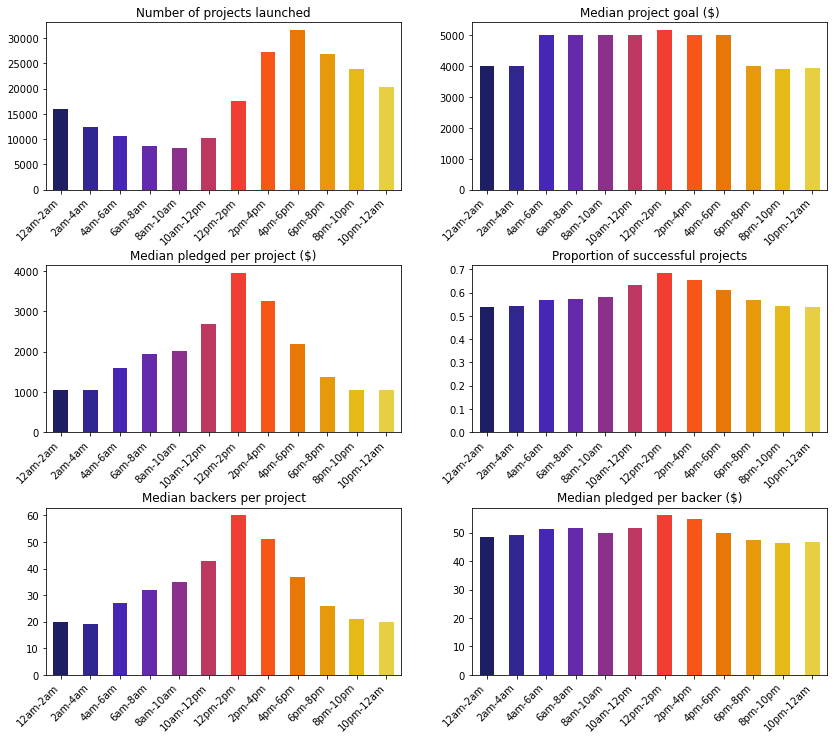

In [32]:
# Creating a dataframe grouped by the time at which they were launched, with columns for failed and successful
time_df = pd.get_dummies(df.set_index('launch_time').state).groupby('launch_time').sum()

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_time.nunique()))

times = ['12am-2am', '2am-4am', '4am-6am', '6am-8am', '8am-10am', '10am-12pm', '12pm-2pm', '2pm-4pm', '4pm-6pm', '6pm-8pm', '8pm-10pm', '10pm-12am']

df.groupby('launch_time').launch_time.count().reindex(times).plot(kind='bar', ax=ax1, color=color, rot=45)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')
ax1.set_xticklabels(labels=ax1.get_xticklabels(), ha='right')

df.groupby('launch_time').usd_goal.median().reindex(times).plot(kind='bar', ax=ax2, color=color, rot=45)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')
ax2.set_xticklabels(labels=ax2.get_xticklabels(), ha='right')

df.groupby('launch_time').usd_pledged.median().reindex(times).plot(kind='bar', ax=ax3, color=color, rot=45)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')
ax3.set_xticklabels(labels=ax3.get_xticklabels(), ha='right')

time_df.div(time_df.sum(axis=1), axis=0).successful.reindex(times).plot(kind='bar', ax=ax4, color=color, rot=45) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')
ax4.set_xticklabels(labels=ax4.get_xticklabels(), ha='right')

df.groupby('launch_time').backers_count.median().reindex(times).plot(kind='bar', ax=ax5, color=color, rot=45)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')
ax5.set_xticklabels(labels=ax5.get_xticklabels(), ha='right')

df.groupby('launch_time').pledge_per_backer.median().reindex(times).plot(kind='bar', ax=ax6, color=color, rot=45)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')
ax6.set_xticklabels(labels=ax6.get_xticklabels(), ha='right')

fig.subplots_adjust(hspace=0.45)
plt.show()

## class imbalance

In [33]:
df['state'].value_counts()

successful    125856
failed         72744
canceled        8960
live            6023
Name: state, dtype: int64

In [34]:
df_state_ = df[(df['state'] == 'successful') | (df['state'] == 'failed')]

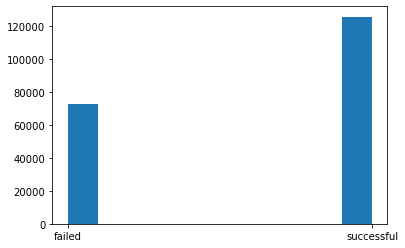

In [35]:
fig,ax=plt.subplots()
ax.hist(df_state_['state']);